In [47]:
!pip install lxml
!pip install seaborn

In [48]:
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.svm import LinearSVC
import joblib
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns # Import the seaborn library and alias it as sns


# Reading dataset as dataframe
df = pd.read_csv("/content/drive/MyDrive/Datasets/cyberbullying_tweets.csv")
pd.set_option('display.max_colwidth', None) # Setting this so we can see the full content of cells
pd.set_option('display.max_columns', None) # to make sure we can see all the columns in output window
df['cyberbullying_type']=df['cyberbullying_type'].map({'religion':1,'age':1,'ethnicity':1,'gender':1,'other_cyberbullying':1,'not_cyberbullying':0})
df.head()

# Cleaning Tweets
def cleaner(tweet):
    soup = BeautifulSoup(tweet, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    souped = soup.get_text()
    re1 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", souped) # substituting @mentions, urls, etc with whitespace
    re2 = re.sub("[^A-Za-z]+"," ", re1) # substituting any non-alphabetic character that repeats one or more times with whitespace

    """
    For more info on regular expressions visit -
    https://docs.python.org/3/howto/regex.html
    """

    tokens = nltk.word_tokenize(re2)
    lower_case = [t.lower() for t in tokens]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t,'v') for t in filtered_result]
    return lemmas

df['cleaned_tweet'] = df.tweet_text.apply(cleaner)
df = df[df['cleaned_tweet'].map(len) > 0] # removing rows with cleaned tweets of length 0
print("Printing top 5 rows of dataframe showing original and cleaned tweets....")
print(df[['tweet_text','cleaned_tweet']].head())

# Saving cleaned tweets to csv
df.to_csv('cleaned_data.csv', index=False)
df['cleaned_tweet'] = [" ".join(row) for row in df['cleaned_tweet'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input
data = df['cleaned_tweet']
Y = df['cyberbullying_type'].reset_index(drop=True) # target column
tfidf = TfidfVectorizer(min_df=.00015, ngram_range=(1,3)) # min_df=.00015 means that each ngram (unigram, bigram, & trigram) must be present in at least 30 documents for it to be considered as a token (200000*.00015=30). This is a clever way of feature engineering
tfidf.fit(data) # learn vocabulary of entire data
data_tfidf = tfidf.transform(data) # creating tfidf values
pd.DataFrame(pd.Series(tfidf.get_feature_names_out())).to_csv('vocabulary.csv', header=False, index=False)
print("Shape of tfidf matrix: ", data_tfidf.shape)

# Implementing Support Vector Classifier
svc_clf = LinearSVC() # kernel = 'linear' and C = 1

# Running cross-validation
def evaluate_model(model, data_tfidf, Y):
  kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
  precision_scores = [] # Initialize precision_scores list

iteration = 0
for train_index, test_index in kf.split(data_tfidf, Y):
    iteration += 1
    print("Iteration ", iteration)
    X_train, Y_train = data_tfidf[train_index], Y[train_index]
    X_test, Y_test = data_tfidf[test_index], Y[test_index]
    model.fit(X_train, Y_train) # Fitting SVC
    Y_pred = model.predict(X_test)
    precision = metrics.precision_score(Y_test, Y_pred, average='macro')  # Calculating precision
    print("Cross-validation precision: ", precision)
    precision_scores.append(precision)  # Appending cross-validation precision for each iteration

mean_precision = np.mean(precision_scores)
print("Mean cross-validation precision: ", mean_precision)


# Creating SVC on entire data and saving it
svc_clf = LinearSVC().fit(data_tfidf, Y)
joblib.dump(clf, 'svc.sav')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-48-a75ab313e514>:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(tweet, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
<ipython-input-48-a75ab313e514>:27: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document 

Printing top 5 rows of dataframe showing original and cleaned tweets....
                                                                                                            tweet_text  \
0                                                        In other words #katandandre, your food was crapilicious! #mkr   
1  Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc   
2                                                         @XochitlSuckkks a classy whore? Or more red velvet cupcakes?   
3              @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.   
4              @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.   

                                                                                             cleaned_tweet  
0                                                             [word, katandandre, foo

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.7406545993865237
Iteration  2


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.7517692605497484
Iteration  3


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.732760350290357
Iteration  4


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.7486948909756486
Iteration  5


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.7360055369410313
Iteration  6


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.7533594799580865
Iteration  7


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.7555176611277294
Iteration  8


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.7453366078302117
Iteration  9


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.7335666461428842
Iteration  10


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cross-validation precision:  0.749800181320714
Mean cross-validation precision:  0.775427256282678


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


['svc.sav']

Iteration 1 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 2 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 3 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 4 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 5 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 6 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 7 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 8 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 9 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Iteration 10 for LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Mean train accuracy for LinearSVC(): 0.9242940003264561
Mean test accuracy for LinearSVC(): 0.8585110672889199
Iteration 1 for MultinomialNB()
Iteration 2 for MultinomialNB()
Iteration 3 for MultinomialNB()
Iteration 4 for MultinomialNB()
Iteration 5 for MultinomialNB()
Iteration 6 for MultinomialNB()
Iteration 7 for MultinomialNB()
Iteration 8 for MultinomialNB()
Iteration 9 for MultinomialNB()
Iteration 10 for MultinomialNB()
Mean train accuracy for MultinomialNB(): 0.8704780436410479
Mean test accuracy for MultinomialNB(): 0.8627185996887541


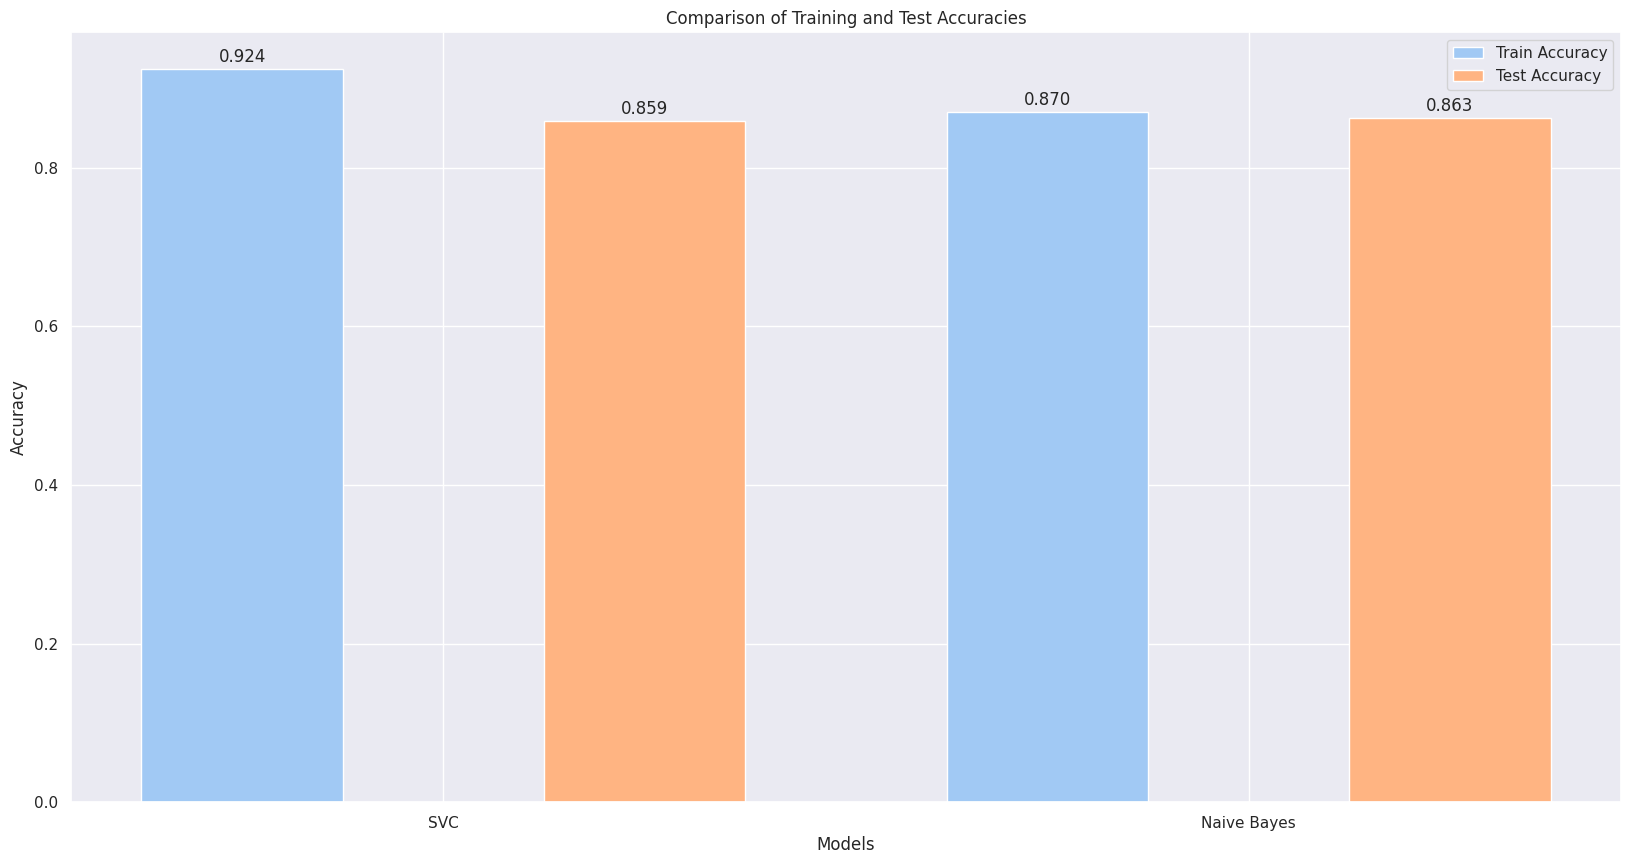

In [58]:
svc_model = LinearSVC()
nbc_model = MultinomialNB()

# Function to perform cross-validation and collect scores
def evaluate_model(model, data_tfidf, Y):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)  # 10-fold cross-validation
    train_scores = []
    test_scores = []
    iteration = 0

    for train_index, test_index in kf.split(data_tfidf, Y):
        iteration += 1
        print(f"Iteration {iteration} for {model}")
        X_train, Y_train = data_tfidf[train_index], Y[train_index]
        X_test, Y_test = data_tfidf[test_index], Y[test_index]
        model.fit(X_train, Y_train)  # Fitting the model
        Y_pred_train = model.predict(X_train)
        Y_pred_test = model.predict(X_test)
        train_acc = metrics.accuracy_score(Y_train, Y_pred_train)  # Calculating train accuracy
        test_acc = metrics.accuracy_score(Y_test, Y_pred_test)  # Calculating test accuracy
        train_scores.append(train_acc)
        test_scores.append(test_acc)

    mean_train_acc = np.mean(train_scores)
    mean_test_acc = np.mean(test_scores)
    print(f"Mean train accuracy for {model}: {mean_train_acc}")
    print(f"Mean test accuracy for {model}: {mean_test_acc}")

    return mean_train_acc, mean_test_acc

# Evaluate models
train_acc_svc, test_acc_svc = evaluate_model(svc_model, data_tfidf, Y)
train_acc_nbc, test_acc_nbc = evaluate_model(nbc_model, data_tfidf, Y)

# Compare the models
train_scores = [train_acc_svc, train_acc_nbc]
test_scores = [test_acc_svc, test_acc_nbc]

models = ['SVC', 'Naive Bayes']

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width, train_scores, width, label='Train Accuracy')
rects2 = ax.bar(x + width, test_scores, width, label='Test Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Training and Test Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


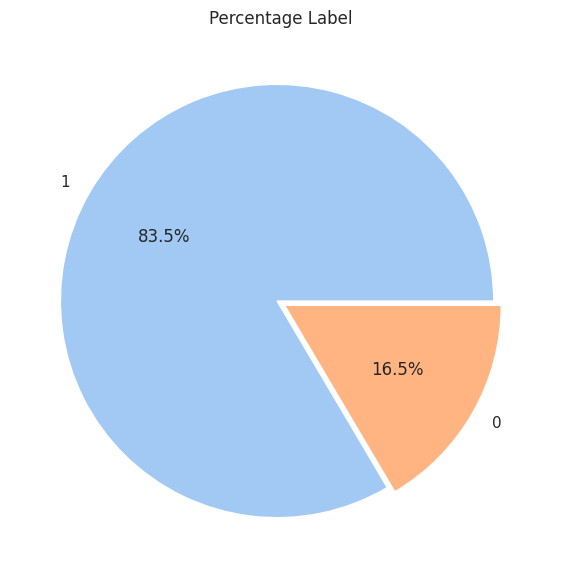

In [53]:
label_count = df['cyberbullying_type'].value_counts()

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

plt.figure(figsize=(10, 6))
plt.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
plt.title('Percentage Label')

plt.tight_layout()
plt.show()

In [50]:
# Implementing Naive Bayes Classifier
nbc_clf = MultinomialNB()

# Running cross-validation
def evaluate_model(model, data_tfidf, Y):
  kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
  precision_scores = [] # Initialize precision_scores list
  iteration = 0
for train_index, test_index in kf.split(data_tfidf, Y):
    iteration += 1
    print("Iteration ", iteration)
    X_train, Y_train = data_tfidf[train_index], Y[train_index]
    X_test, Y_test = data_tfidf[test_index], Y[test_index]
    nbc_clf.fit(X_train, Y_train) # Fitting NBC
    Y_pred = nbc_clf.predict(X_test)
    precision = metrics.precision_score(Y_test, Y_pred, average='macro')  # Calculating precision
    print("Cross-validation precision: ", precision)
    precision_scores.append(precision)  # Appending cross-validation precision for each iteration

mean_precision = np.mean(precision_scores)
print("Mean cross-validation precision: ", mean_precision)


# Creating NBC on entire data and saving it
nbc_clf = MultinomialNB().fit(data_tfidf, Y)
joblib.dump(nbc_clf, 'nbc.sav')

    return mean_train_acc, mean_test_acc



Iteration  11
Cross-validation precision:  0.8087876669773222
Iteration  12
Cross-validation precision:  0.8108636847495081
Iteration  13
Cross-validation precision:  0.8071593651211906
Iteration  14
Cross-validation precision:  0.8024833082627398
Iteration  15
Cross-validation precision:  0.7916759964173757
Iteration  16
Cross-validation precision:  0.8163350969328986
Iteration  17
Cross-validation precision:  0.7912493546721735
Iteration  18
Cross-validation precision:  0.810125301419717
Iteration  19
Cross-validation precision:  0.8131278361082188
Iteration  20
Cross-validation precision:  0.8092723004694835
Mean cross-validation precision:  0.7798102184013044


['nbc.sav']

EDA

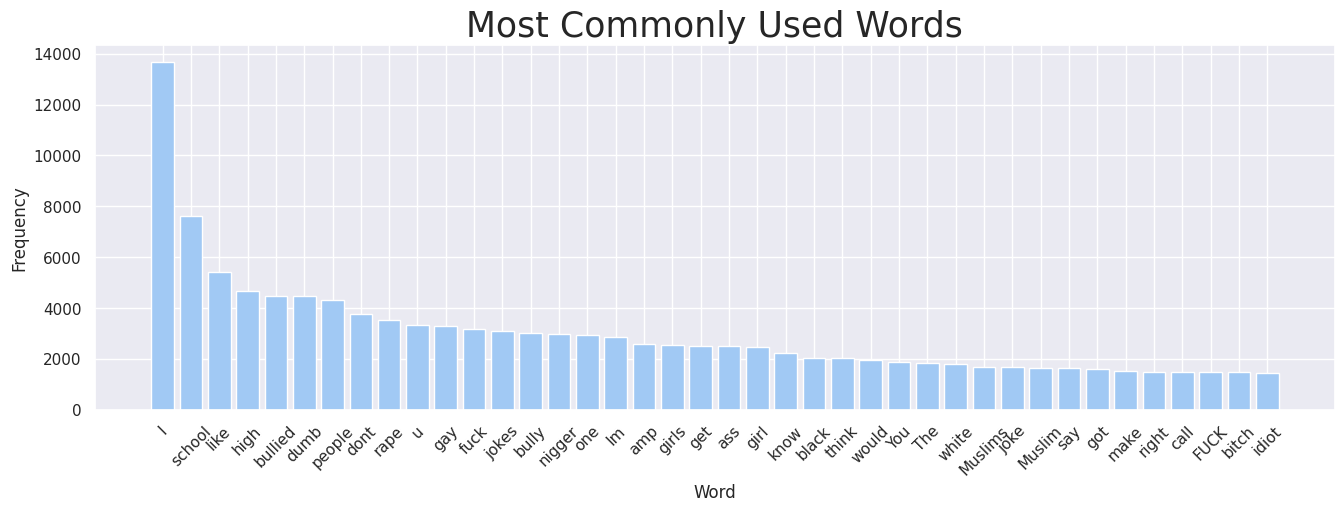

In [51]:
# Import Counter from collections
from collections import Counter
import matplotlib.pyplot as plt

def Most_Words_used(tweets , num_of_words) :
    all_text = ''.join(df[tweets].values)

    all_text = re.sub(r'http\S+', '', all_text)
    all_text = re.sub(r'@\S+', '', all_text)
    all_text = re.sub(r'#\S+', '', all_text)
    all_text = re.sub(r'\d+', '',all_text)
    all_text = re.sub(r'[^\w\s]', '',all_text)


    words = all_text.split()

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    word_counts = Counter(words)

    top_words = word_counts.most_common(num_of_words)

    return top_words

top_words = Most_Words_used('tweet_text' , 40)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()